In [1]:
# # uncomment in order to download the dataset
# !aws s3 sync s3://openproblems-bio/public/phase2-private-data/match_modality/ ./datasets/ --no-sign-request

In [2]:
!nvidia-smi

Thu Apr 27 19:51:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:15:00.0 Off |                    0 |
| N/A   36C    P0    65W / 300W |   1122MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:16:00.0 Off |                    0 |
| N/A   

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE='cuda'

### Imports

In [4]:
import torch
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

import catalyst
import shutil
import pickle
import optuna

import neptune
import random

from sklearn.model_selection import LeaveOneGroupOut
from datetime import datetime
from torch import nn
import torch.nn.functional as F
from catalyst import dl, utils
from tqdm.notebook import tqdm

from src.data import get_dataloaders, ModalityMatchingDataset
from src.models import Modality_CLIP, Encoder, symmetric_npair_loss
from src.catalyst_tools import scRNARunner, CustomMetric
from src.preprocessing import lsiTransformer

### Configuration

In [5]:
DEFAULT_RANDOM_SEED = 777

def seedEverything(seed=DEFAULT_RANDOM_SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seedEverything(DEFAULT_RANDOM_SEED)

In [6]:
first_modality = 'ADT'
assert first_modality in ['ADT', 'ATAC']
#second modality is GEX anyway
if first_modality == 'ATAC':
    import src.config_ATAC2GEX as config
else:
    import src.config_ADT2GEX as config

In [7]:
VALIDATION_FOLD = 0
TRAIN_CLIP_FROM_SCRATCH = False
PRETRAINED_ARTIFACTS_FOLDER = './dumps/ADT2GEX/Feb12_00_53_45/0/'

In [8]:
current_time = datetime.now().strftime("%b%d_%H_%M_%S")

### Setting up the data

In [9]:
if TRAIN_CLIP_FROM_SCRATCH:
    dump_folder = os.path.join(config.MODEL_DUMPS_STORAGE, f'{first_modality}2GEX', current_time)
    logger_folder = os.path.join(config.TENSORBOARD_DUMPS_STORAGE, f'{first_modality}2GEX', current_time)
    os.makedirs(dump_folder)
    shutil.copy2(config.__file__, dump_folder)

In [10]:
adata_first = ad.read_h5ad(config.PATH_FIRST_TRAIN)
adata_gex = ad.read_h5ad(config.PATH_GEX_TRAIN)
sol_train = ad.read_h5ad(config.PATH_TARGET_TRAIN)
adata_gex = adata_gex[sol_train.to_df().values.argmax(1)]

In [11]:
adata_first_test = ad.read_h5ad(config.PATH_FIRST_TEST)
adata_gex_test = ad.read_h5ad(config.PATH_GEX_TEST)
sol_test = ad.read_h5ad(config.PATH_TARGET_TEST)
adata_gex_test = adata_gex_test[sol_test.to_df().values.argmax(1)]

In [12]:
logo = LeaveOneGroupOut()
groups = sol_train.obs.batch
logo.get_n_splits(adata_gex, groups=groups)

9

In [13]:
train_index, val_index = list(logo.split(adata_gex, groups=groups))[VALIDATION_FOLD]

In [14]:
if TRAIN_CLIP_FROM_SCRATCH:
    trial_logger_folder = os.path.join(logger_folder, str(VALIDATION_FOLD))
    trial_dump_folder = os.path.join(dump_folder, str(VALIDATION_FOLD))
    os.makedirs(trial_dump_folder, exist_ok=True)
    
    if first_modality == 'ATAC':
        lsi_transformer_atac = lsiTransformer(n_components=config.N_LSI_COMPONENTS_FIRST, drop_first=True)
        first_modality_train = lsi_transformer_atac.fit_transform(adata_first[train_index])
        with open(os.path.join(trial_dump_folder, f'lsi_ATAC_transformer.pickle'), 'wb') as outfile:
            pickle.dump(lsi_transformer_atac, outfile)
    else:
        first_modality_train = adata_first[train_index].to_df()

    lsi_transformer_gex = lsiTransformer(n_components=config.N_LSI_COMPONENTS_GEX, drop_first=True)
    gex_train = lsi_transformer_gex.fit_transform(adata_gex[train_index])
    with open(os.path.join(trial_dump_folder, 'lsi_GEX_transformer.pickle'), 'wb') as outfile:
        pickle.dump(lsi_transformer_gex, outfile)
else:
    if first_modality == 'ATAC':
        with open(os.path.join(PRETRAINED_ARTIFACTS_FOLDER, 'lsi_ATAC_transformer.pickle'), 'rb') as f:
            lsi_transformer_atac = pickle.load(f)
        first_modality_train = lsi_transformer_atac.transform(adata_first[train_index])
    else:
        first_modality_train = adata_first[train_index].to_df()
        
    with open(os.path.join(PRETRAINED_ARTIFACTS_FOLDER, 'lsi_GEX_transformer.pickle'), 'rb') as f:
        lsi_transformer_gex =  pickle.load(f)
        gex_train = lsi_transformer_gex.transform(adata_gex[train_index])

In [15]:
if first_modality == 'ATAC':
    first_modality_val = lsi_transformer_atac.transform(adata_first[val_index])
    first_modality_test = lsi_transformer_atac.transform(adata_first_test)
else:
    first_modality_val = adata_first[val_index].to_df()
    first_modality_test = adata_first_test.to_df()
gex_val =  lsi_transformer_gex.transform(adata_gex[val_index])
gex_test =  lsi_transformer_gex.transform(adata_gex_test)

In [16]:
dataset_train = ModalityMatchingDataset(first_modality_train, gex_train)
dataset_val = ModalityMatchingDataset(first_modality_val, gex_val)
dataset_test = ModalityMatchingDataset(first_modality_test, gex_test)

In [102]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, config.BATCH_SIZE, shuffle = True, drop_last=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, 2048, shuffle = False)
dataloader_test = torch.utils.data.DataLoader(dataset_test, 2048, shuffle = False)

### Instantiating the model

In [18]:
model = Modality_CLIP(
    Encoder=Encoder, 
    layers_dims = (
      config.LAYERS_DIM_FIRST, 
      config.LAYERS_DIM_GEX
    ),
    dropout_rates = (
      config.DROPOUT_RATES_FIRST, 
      config.DROPOUT_RATES_GEX
    ),
    dim_mod1 = 134 if first_modality == 'ADT' else config.N_LSI_COMPONENTS_FIRST,
    dim_mod2 = config.N_LSI_COMPONENTS_GEX, 
    output_dim = config.EMBEDDING_DIM,
    T = config.LOG_T,
    swap_rate_1 = 0.,
    swap_rate_2 = 0.)

In [19]:
if TRAIN_CLIP_FROM_SCRATCH:
    optimizer = torch.optim.Adam(model.parameters(), config.LR, weight_decay=config.weight_decay)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=50)

    loaders = {
        "train": dataloader_train,
        "valid": dataloader_val,
    }
    runner = scRNARunner(
)

    # model training
    runner.train(
        model=model,
        optimizer=optimizer,
        loaders=loaders,
        num_epochs=config.N_EPOCHS,
        #scheduler=scheduler,
        loggers = {
            'tb':catalyst.dl.TensorboardLogger(
                logdir=trial_logger_folder
            )
        },
        callbacks=[
            #dl.OptimizerCallback(metric_key='loss'),
            dl.CheckpointCallback(
                logdir = trial_dump_folder,
                loader_key='valid',
                metric_key='avg_acc',
                minimize=False,
                #use_runner_logdir=False,
                #save_n_best=1
            ),
            dl.EarlyStoppingCallback(
                patience=150,
                loader_key='valid',
                metric_key='avg_acc',
                minimize=False,
                min_delta=1e-5),
            dl.LoaderMetricCallback(
                metric=CustomMetric(),
                input_key=['embeddings_first', 'embeddings_second', 'temperature'],
                target_key=['embeddings_second']
            ),
            #dl.SchedulerCallback(loader_key='valid', metric_key='avg_acc'),
           # dl.CheckRunCallback(num_batch_steps=1, num_epoch_steps=50)
        ],
        #valid_metric='loss',
        #valid_loader='valid',
        verbose=True
    )

### Validation and postprocessing

In [20]:
if not TRAIN_CLIP_FROM_SCRATCH:
    print('loading pretrained model')
    model.load_state_dict(torch.load(os.path.join(PRETRAINED_ARTIFACTS_FOLDER, 'model.last.pth')))
    model.cuda()

loading pretrained model


In [21]:
model.eval()
embedding_list_first = []
embedding_list_gex = []
for batch in dataloader_test:
    with torch.no_grad():
        features_first = batch['features_first'].cuda()
        features_gex = batch['features_second'].cuda()
        logits, embeddings_first, embeddings_gex = model(features_first, features_gex)
        embedding_list_first.append(embeddings_first)
        embedding_list_gex.append(embeddings_gex)

In [22]:
embeddings_first = torch.cat(embedding_list_first)
embeddings_gex = torch.cat(embedding_list_gex)

In [23]:
test_similarities = embeddings_first@embeddings_gex.transpose(1,0)

In [24]:
test_similarities_numpy = test_similarities.cpu().numpy()

In [25]:
#naive matching - just taking closest one to each query with no regard to mutual exclusivity
adjacency_naive = test_similarities_numpy == np.max(test_similarities_numpy, 1, keepdims=True)
np.diag(adjacency_naive).mean()

0.020974379397318464

In [26]:
#one can see that one 2nd modality candidate can be a best fit for a lot more than 1 candidate in the 1st modality

In [27]:
adjacency_naive.sum(0)

array([ 4,  0,  5, ...,  0,  0, 17])

#### Advanced matching

In [28]:
%load_ext autoreload
%autoreload 2

In [29]:
from src.postprocessing import get_bipartite_matching_adjacency_matrix, get_OT_adjacency_matrix

In [30]:
adjacency_bipartite = get_bipartite_matching_adjacency_matrix(test_similarities_numpy)

In [31]:
np.diag(adjacency_bipartite).mean()

0.02880658436213992

In [32]:
### checking that we've built a mutually exclusive matching

In [33]:
np.all(adjacency_bipartite.sum(0)==1.)

True

In [35]:
#this gives the matrix which elements sums up to 1 totally, not row-wise or column-wise
raw_adjacency_ot = get_OT_adjacency_matrix(model.logit_scale.exp()*test_similarities, entropy_reg=0.01).detach().cpu().numpy()

In [36]:
hard_adjacency_ot = (raw_adjacency_ot == np.max(raw_adjacency_ot, axis=1, keepdims=True))

In [37]:
assert(np.all(hard_adjacency_ot.sum(1)==1.))

In [38]:
#the best one so far
np.diag(hard_adjacency_ot).mean()

0.031527943714323645

In [39]:
soft_adjacency_ot = raw_adjacency_ot/raw_adjacency_ot.sum(1,keepdims=True)

In [40]:
#decreasing the entropy_reg making the things better for soft matching but worse for hard
np.diag(soft_adjacency_ot).mean()

0.017720973

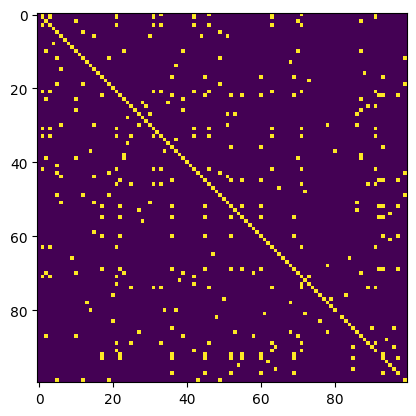

In [41]:
plt.imshow(soft_adjacency_ot[:100,:100]>1e-5)

In [42]:
def zero_out_except_top_k(matrix, k):
    # Make a copy of the input matrix
    output_matrix = matrix.copy()

    # Iterate over the rows of the matrix
    for i in range(matrix.shape[0]):
        # Get the indices of the k largest elements in this row
        top_k_indices = np.argpartition(-matrix[i, :], k)[:k]

        # Zero out all elements except the top k
        output_matrix[i, np.setdiff1d(np.arange(matrix.shape[1]), top_k_indices)] = 0

    return output_matrix

In [43]:
topk_metrics = []
for topk in tqdm(range(1,20)):
    ot_matrix_postproc = zero_out_except_top_k(soft_adjacency_ot, topk)
    ot_matrix_postproc /=  ot_matrix_postproc.sum(1, keepdims=True) 
    topk_metrics.append(np.diag(ot_matrix_postproc).mean())

  0%|          | 0/19 [00:00<?, ?it/s]

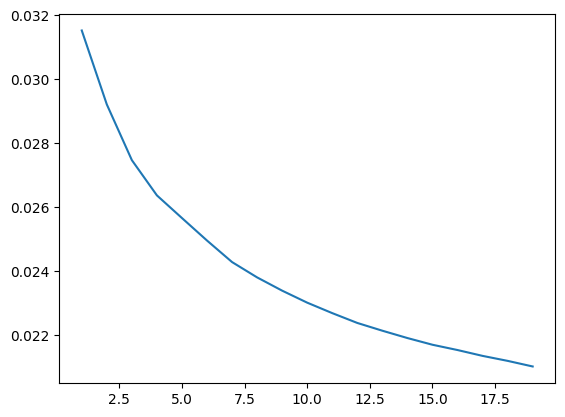

In [44]:
plt.plot(list(range(1,20)), topk_metrics)

In [45]:
topk_metrics[0]

0.031527944

In [46]:
from scipy.stats import rankdata

In [47]:
rank_matrix_on_similarities = np.array([rankdata(-row) for row in test_similarities_numpy])

In [48]:
rank_matrix_on_ot_softmatching = np.array([rankdata(-row) for row in soft_adjacency_ot])

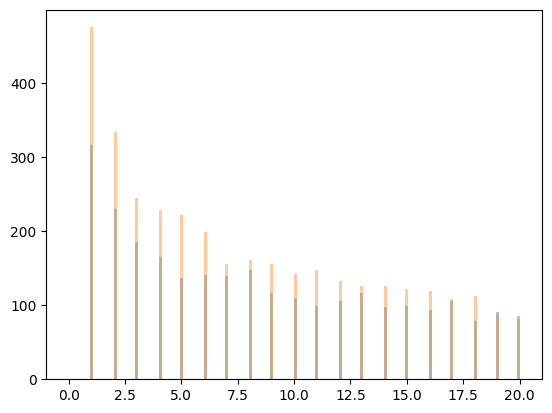

In [49]:
#ot matching yields higher rank of true positives
plt.hist(np.diag(rank_matrix_on_similarities),bins=150, alpha=0.4, range=(0,20));
plt.hist(np.diag(rank_matrix_on_ot_softmatching),bins=150, alpha=0.4, range=(0,20));

In [50]:
#We could reach thic accuracy if we re-rank 20 best candidates perfectly
(np.diag(rank_matrix_on_ot_softmatching) < 20).mean()

0.22554095313951944

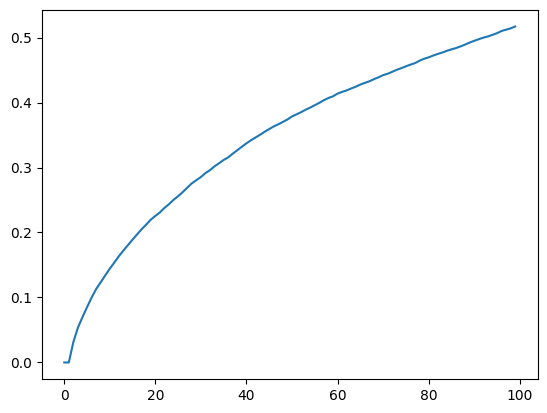

In [51]:
#theoretical limit of reranking based on topk
plt.plot([(np.diag(rank_matrix_on_ot_softmatching) < i).mean() for i in range(100)])

### Reranking (custom)

#### Siamese reranking (needs more cleanup)

In [ ]:
from pprint import pprint

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from oml.datasets.base import DatasetWithLabels, DatasetQueryGallery
from oml.inference.flat import inference_on_dataframe
from oml.metrics.embeddings import EmbeddingMetrics
from oml.miners.pairs import PairsMiner
from oml.models.siamese import ConcatSiamese
from oml.models.vit.vit import ViTExtractor
from oml.retrieval.postprocessors.pairwise import PairwiseImagesPostprocessor
from oml.samplers.balance import BalanceSampler
from oml.transforms.images.torchvision.transforms import get_normalisation_resize_torch
from oml.utils.download_mock_dataset import download_mock_dataset

In [ ]:
siamese = nn.Sequential(nn.Linear(262,2048),
                        nn.ReLU(),
                        nn.Linear(2048,1),
                       ).cuda()

In [ ]:
# # Let's start with saving embeddings of a pretrained extractor for which we want to build a postprocessor
# dataset_root = "mock_dataset/"
# download_mock_dataset(dataset_root)

# extractor = ViTExtractor("vits16_dino", arch="vits16", normalise_features=False)
# transform = get_normalisation_resize_torch(im_size=64)

# embeddings_train, embeddings_val, df_train, df_val = \
#     inference_on_dataframe(dataset_root, "df.csv", extractor=extractor, transforms_extraction=transform)

# # We are building Siamese model on top of existing weights and train it to recognize positive/negative pairs
# siamese = ConcatSiamese(extractor=extractor, mlp_hidden_dims=[100])
optimizer = torch.optim.AdamW(siamese.parameters(), lr=1e-3)
# miner = PairsMiner(hard_mining=True)
criterion = BCEWithLogitsLoss()

In [ ]:
next(iter(dataloader_train))['features_first'].shape

In [ ]:
# train_dataset = DatasetWithLabels(df=df_train, transform=transform, extra_data={"embeddings": embeddings_train})
# batch_sampler = BalanceSampler(train_dataset.get_labels(), n_labels=2, n_instances=2)
#train_loader = DataLoader(train_dataset, batch_sampler=batch_sampler)
for epoch in range(300):
    losses = []
    siamese.train()
    for batch in dataloader_train:
        # We sample pairs on which the original model struggled most
        # ids1, ids2, is_negative_pair = miner.sample(features=batch["embeddings"], labels=batch["labels"])
        # probs = siamese(x1=batch["input_tensors"][ids1], x2=batch["input_tensors"][ids2])
        # loss = criterion(probs, is_negative_pair.float())

        logits, embs_first, embs_gex = model(batch['features_first'].cuda(), batch['features_second'].cuda())
        
        n_samples = logits.shape[0]
        logits[torch.arange(n_samples).cuda(),torch.arange(n_samples).cuda()] = -torch.inf
        hard_indices = torch.argmax(logits, dim=1)
        positives = torch.cat([batch['features_first'],
                               batch['features_second']],dim=1).cuda()
        negatives = torch.cat([batch['features_first'].cuda(), 
                               batch['features_second'].cuda()[hard_indices]],dim=1)
        positive_predictions  = siamese(positives)
        negative_predictions = siamese(negatives)
        pos_loss = criterion(positive_predictions, torch.zeros((n_samples,1)).cuda())
        neg_loss = criterion(negative_predictions, torch.ones((n_samples,1)).cuda())

        loss = pos_loss+neg_loss

        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        optimizer.zero_grad()
    
    siamese.eval()
    val_losses = []
    for batch in dataloader_val:
        # We sample pairs on which the original model struggled most
        # ids1, ids2, is_negative_pair = miner.sample(features=batch["embeddings"], labels=batch["labels"])
        # probs = siamese(x1=batch["input_tensors"][ids1], x2=batch["input_tensors"][ids2])
        # loss = criterion(probs, is_negative_pair.float())

        logits, embs_first, embs_gex = model(batch['features_first'].cuda(), batch['features_second'].cuda())

        n_samples = logits.shape[0]
        logits[torch.arange(n_samples).cuda(),torch.arange(n_samples).cuda()] = -torch.inf
        hard_indices = torch.argmax(logits, dim=1)
        positives = torch.cat([batch['features_first'],
                               batch['features_second']],dim=1).cuda()
        negatives = torch.cat([batch['features_first'].cuda(), 
                               batch['features_second'].cuda()[hard_indices]],dim=1)
        positive_predictions  = siamese(positives)
        negative_predictions = siamese(negatives)
        pos_loss = criterion(positive_predictions, torch.zeros((n_samples,1)).cuda())
        neg_loss = criterion(negative_predictions, torch.ones((n_samples,1)).cuda())

        loss = pos_loss+neg_loss

       
        val_losses.append(loss.item())
    if not epoch%10:
        print(f'Train loss: {np.mean(losses)}, val loss: {np.mean(val_losses)}')

#### Discriminative reranking

In [154]:
class LSTMpostprocessor(nn.Module):
    def __init__(self):
        super(LSTMpostprocessor, self).__init__()
        self.lstm = nn.LSTM(268, hidden_size=256, num_layers=2, bidirectional=True)
        self.head = nn.Sequential(nn.Linear(512,512), nn.ReLU(), nn.Linear(512,1))
    def forward(self, x):
        c,h = self.lstm(x)
        logits = self.head(c).squeeze()
        return logits
    
class Attnpostprocessor(nn.Module):
    def __init__(self):
        super(Attnpostprocessor, self).__init__()
        self.attn = nn.TransformerEncoderLayer(268, nhead=4, dropout=0.5)
        self.head = nn.Sequential(nn.Linear(268,1))
    def forward(self, x):
        out = self.attn(x)
        logits = self.head(out).squeeze()
        return logits

In [163]:
sorter = Attnpostprocessor().cuda()
optimizer = torch.optim.AdamW(sorter.parameters(), lr=1e-4)

In [164]:
sum(p.numel() for p in model.parameters())

1946753

In [165]:
sum(p.numel() for p in sorter.parameters())

1389753

In [166]:
embedding_list_first = []
embedding_list_gex = []
for batch in dataloader_val:
    with torch.no_grad():
        features_first = batch['features_first'].cuda()
        features_gex = batch['features_second'].cuda()
        logits, embeddings_first, embeddings_gex = model(features_first, features_gex)
        embedding_list_first.append(embeddings_first)
        embedding_list_gex.append(embeddings_gex)

val_distances = torch.exp(model.logit_scale)*torch.cat(embedding_list_first)@torch.cat(embedding_list_gex).transpose(1,0)

val_matching_raw = get_OT_adjacency_matrix(val_distances)

val_matching_soft = val_matching_raw/val_matching_raw.sum(1, keepdims=True)

In [167]:
#soft matching metric
torch.diag(val_matching_soft).mean().item()

0.048209331929683685

In [168]:
#hard matching metric
torch.diag(val_matching_raw == val_matching_raw.max(dim=1, keepdims=True)[0]).float().mean().item()

0.08811692148447037

In [169]:
loss_fn = nn.CrossEntropyLoss()

In [170]:
TOPK=3
for epoch in range(10):
    losses = []
    sorter.train();
    for batch in dataloader_train:
        logits, embs_first, embs_gex = model(batch['features_first'].cuda(), batch['features_second'].cuda())
        #some noise so that we select a bit different hard negatives
        logits += torch.randn(*logits.shape, device='cuda')
        batch_size = embs_first.shape[0]
        #making sure that true positives are picked and they are the first
        logits[torch.arange(logits.shape[0]), torch.arange(logits.shape[0])] = torch.inf
        maxima, max_indices = torch.topk(logits, TOPK, axis=1)

        queries = batch['features_first'].unsqueeze(1).repeat(1,TOPK,1).cuda().detach()
        values = batch['features_second'].cuda()[max_indices].detach()
        sorter_input = torch.cat([queries, values], axis=2)



        optimizer.zero_grad()
        sorter_output = sorter(sorter_input)
        target = torch.zeros(batch_size, dtype=torch.long).cuda()
        loss = loss_fn(sorter_output, target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    

    sorter.eval()
    maxima, max_indices = torch.topk(val_matching_raw, TOPK, axis=1)

    queries = torch.Tensor(dataset_val.df_modality1).unsqueeze(1).repeat(1,TOPK,1).cuda().detach()
    values = torch.Tensor(dataset_val.df_modality2).cuda()[max_indices].detach()

    sorter_input = torch.cat([queries, values], axis=2)
    sorter_output = nn.Softmax(dim=1)(sorter(sorter_input))

    val_metric_postproc_soft = (sorter_output*(max_indices == torch.arange(max_indices.shape[0])[:,None].cuda())).sum(1).mean().item()
    if not epoch%1:
        print(f"Epoch {epoch}")
        print(np.mean(losses))
        print(val_metric_postproc_soft)

Epoch 0
1.1115876237551372
0.05784418433904648
Epoch 1
1.0968463977177938
0.05789191648364067
Epoch 2
1.0820770223935445
0.05784173309803009
Epoch 3
0.9919199625651042
0.057514067739248276
Epoch 4
0.5304605861504873
0.05776321142911911
Epoch 5
0.3232648142923911
0.057594478130340576
Epoch 6
0.18111750117192665
0.057484280318021774
Epoch 7
0.19213589262217284
0.057434894144535065
Epoch 8
0.1293725848197937
0.057591717690229416
Epoch 9
0.09289826316138108
0.05768140032887459


In [171]:
adjacency_reranked_val = np.zeros(val_matching_raw.shape)

In [172]:
row_indices = np.arange(val_matching_raw.shape[0]).reshape(-1, 1)
adjacency_reranked_val[row_indices,max_indices.cpu().numpy()] = sorter_output.detach().cpu().numpy()

In [176]:
sorter_output

tensor([[0.3238, 0.3213, 0.3550],
        [0.3224, 0.3297, 0.3479],
        [0.3301, 0.3105, 0.3594],
        ...,
        [0.3251, 0.3369, 0.3381],
        [0.3226, 0.3229, 0.3545],
        [0.3143, 0.3149, 0.3708]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [173]:
#why?
from collections import Counter
Counter(sorter_output.argmax(1).cpu().numpy())

Counter({2: 4582, 0: 115, 1: 24})

In [174]:
np.diag(adjacency_reranked_val).mean()

0.05768140137915236

In [175]:
np.diag(adjacency_reranked_val == np.max(adjacency_reranked_val, 1, keepdims=True)).mean()

0.04299936454141072

In [89]:
batch = next(iter(dataloader_train))

In [90]:
#batch overfitting test
for trial in range(100):
    sorter.train()
    logits, embs_first, embs_gex = model(batch['features_first'].cuda(), batch['features_second'].cuda())
    batch_size = embs_first.shape[0]
    logits[torch.arange(logits.shape[0]),torch.arange(logits.shape[0])] = -torch.inf
    maxima, max_indices = torch.topk(logits, 9, axis=1)
    max_indices = torch.cat([torch.arange(batch_size).unsqueeze(1).cuda(), max_indices], dim=1)

    target = torch.zeros(batch_size, dtype=torch.long).cuda()

    queries = batch['features_first'].unsqueeze(1).repeat(1,10,1).cuda().detach()
    values = batch['features_second'].cuda()[max_indices].detach()
    sorter_input = torch.cat([queries, values], axis=2)



    optimizer.zero_grad()
    sorter_output = sorter(sorter_input)
    target = torch.zeros(batch_size, dtype=torch.long).cuda()
    loss = loss_fn(sorter_output, target)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if not trial%1:
        print(loss.item())

### Refinement (OML) (don't look here yet too)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from IPython.core.display import HTML
from IPython.display import display

display(HTML("<style>.container { width:100% !important; }</style>"))


from pprint import pprint
from tqdm.auto import tqdm

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from oml.datasets.base import DatasetQueryGallery
from oml.metrics.embeddings import EmbeddingMetrics
from oml.retrieval.postprocessors.pairwise import PairwiseEmbeddingsPostprocessor
from oml.samplers.category_balance import CategoryBalanceSampler
from oml.samplers.balance import BalanceSampler
from oml import const

from src.refinement import BioDatasetWithLabels, BioDatasetQueryGallery, SimpleSiamese, SimpleExtractor, PairsSamplerTwoModalities

In [ ]:
import oml

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
# DATA

# I assume that descriptors of both types will have the same size after PCA
feat_dim_after_pca = config.N_LSI_COMPONENTS_GEX
hospital_encoder = LabelEncoder()
categories_ = hospital_encoder.fit_transform(sol_train.obs.batch[train_index])
categories = np.concatenate([categories_, categories_])
# index          0  1  2  3  4  5  6  7
#labels =        [0, 0, 1, 1, 2, 2, 3, 3]
labels = list(range(first_modality_train.shape[0]))*2
#categories =    [0, 0, 0, 0, 1, 1, 1, 1]  # this is a hospital id
categories_ = hospital_encoder.fit_transform(sol_train.obs.batch[train_index])
categories = np.concatenate([categories_, categories_])
#is_first_type = [1, 0, 1, 0, 1, 0, 1, 0]
is_first_type = np.concatenate([np.ones(first_modality_train.shape[0]),
                                np.zeros(first_modality_train.shape[0])])
#descriptors =   torch.randn((len(labels), feat_dim_after_pca))
descriptors = torch.cat([torch.Tensor(first_modality_train.values), torch.Tensor(gex_train.values)]).cuda()

labels2category = dict(zip(labels, categories))  # label to hospital id

In [ ]:
from copy import deepcopy

In [ ]:
#extractor1 = SimpleExtractor(in_dim=feat_dim_after_pca, out_dim=config.EMBEDDING_DIM)
#extractor2 = SimpleExtractor(in_dim=feat_dim_after_pca, out_dim=18)
extractor1 = deepcopy(model.encoder_modality1)
extractor2 = deepcopy(model.encoder_modality2)

siamese = SimpleSiamese(extractor1=extractor1, extractor2=extractor2).train().cuda()
optimizer = torch.optim.AdamW(siamese.parameters(), lr=1e-4)
miner = PairsSamplerTwoModalities(hard=False)  # it will not remember all the pairs since we overfit only on the hard ones
criterion = BCEWithLogitsLoss()

train_dataset = BioDatasetWithLabels(labels, categories, is_first_type, descriptors)
# batch_sampler = CategoryBalanceSampler(train_dataset.get_labels(), label2category=labels2category, n_labels=2, n_instances=2, n_categories=2)
batch_sampler = BalanceSampler(train_dataset.get_labels(), n_labels=4, n_instances=16)
train_loader = DataLoader(train_dataset, batch_sampler=batch_sampler)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
features_a = batch[const.INPUT_TENSORS_KEY][batch["is_first_type"]]
features_b = batch[const.INPUT_TENSORS_KEY][~batch["is_first_type"]]
labels_a = batch[const.LABELS_KEY][batch["is_first_type"]]
labels_b = batch[const.LABELS_KEY][~batch["is_first_type"]]

ids1, ids2, is_negative_pair = miner.sample(features_a, features_b, labels_a, labels_b)

In [ ]:
#n_epochs = 50000
n_epochs = 5

for _ in tqdm(range(n_epochs), position=0):
    for batch in tqdm(train_loader, leave=False, position=1):
        features_a = batch[const.INPUT_TENSORS_KEY][batch["is_first_type"]]
        features_b = batch[const.INPUT_TENSORS_KEY][~batch["is_first_type"]]
        labels_a = batch[const.LABELS_KEY][batch["is_first_type"]]
        labels_b = batch[const.LABELS_KEY][~batch["is_first_type"]]
        
        ids1, ids2, is_negative_pair = miner.sample(features_a, features_b, labels_a, labels_b)
        probs = siamese(x1=features_a[ids1], x2=features_b[ids2])  # can think about it as distances
        loss = criterion(probs, is_negative_pair.float().cuda())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(loss.item())

In [ ]:
#torch.save(siamese.state_dict, 'siamese.pickle')

### Custom eval

In [ ]:
siamese.eval();

In [ ]:
postproc_matrix  = torch.zeros(test_distances_numpy.shape)

In [ ]:
plt.hist((adj_matrix_ot_norm>1e-3).sum(1), bins=50);

In [ ]:
ind_first, ind_gex = np.where((adj_matrix_ot_norm>1e-2))

In [ ]:
feat_first = torch.Tensor(first_modality_test.values).cuda()
feat_gex = torch.Tensor(gex_test.values).cuda()

In [ ]:
index_dataset = torch.utils.data.TensorDataset(torch.LongTensor(ind_first), torch.LongTensor(ind_gex))

In [ ]:
for ind1, ind2 in tqdm(torch.utils.data.DataLoader(index_dataset, batch_size=2048)):
    x1 = feat_first[ind1]
    x2 = feat_gex[ind2]
    ans = torch.sigmoid(siamese(x1, x2)).detach().cpu()
    postproc_matrix[ind1, ind2] = ans

In [ ]:
postproc_matrix = postproc_matrix.cpu().numpy()

In [ ]:
postproc_matrix.sum(1)

In [ ]:
postproc_matrix /= (postproc_matrix.sum(1, keepdims=True)+1e-12)

In [ ]:
np.diag(postproc_matrix == postproc_matrix.max(1,keepdims=True)).mean()

In [ ]:
from collections import Counter

In [ ]:
np.diag(adj_matrix_ot_norm).mean()

In [ ]:
np.diag(postproc_matrix).mean()

In [ ]:
tmp = OT_matching(postproc_matrix, entropy_reg=0.1)

In [ ]:
tmp/=tmp.sum(1,keepdims=True)

In [ ]:
np.diag(tmp).mean()

### OML eval

In [ ]:
descriptors_test = torch.cat([torch.Tensor(first_modality_test.values),torch.Tensor(gex_test.values)])
is_first_test = np.concatenate([np.ones(gex_test.shape[0]), np.zeros(gex_test.shape[0])])
labels_test = list(range(gex_test.shape[0]))*2

In [ ]:
fir

In [ ]:
# %debug
siamese.eval()

val_dataset = BioDatasetQueryGallery(labels_test, is_first_test, descriptors_test)
valid_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

postprocessor = PairwiseEmbeddingsPostprocessor(top_n=1000, pairwise_model=siamese, num_workers=0, batch_size=64)
calculator = EmbeddingMetrics(
    cmc_top_k=(1,5),
    postprocessor=postprocessor
)
calculator.setup(num_samples=len(val_dataset))

for batch in valid_loader:
    calculator.update_data(data_dict=batch)

# Note! I don't apply sigmoid on top of siamese model's output. I will fix it in the next PR soon!!!
calculator.compute_metrics();  # Pairwise inference happens here

In [ ]:
postprocessed_matrix = calculator.distance_matrix.clone()

In [ ]:
adj_matrix_postproc = get_bipartite_matching_adjacency_matrix_mk3(postprocessed_matrix.cpu().numpy(),
                                                                  threshold_quantile=0.900)

In [ ]:
adj_matrix_ot_postproc = OT_matching(postprocessed_matrix.cuda()).cpu().numpy()

In [ ]:
adj_matrix_ot_postproc_norm = adj_matrix_ot_postproc/adj_matrix_ot_postproc.sum(1, keepdims=True)

In [ ]:
np.diag(adj_matrix_ot_postproc_norm).mean()

In [ ]:
plt.imshow(adj_matrix_ot_norm)